In [1]:
try:
    if installed:
        print('Installed')
except:
    !pip install -q gym[atari,accept-rom-license] ale-py
    !pip install torch-summary
    !pip --disable-pip-version-check install -q pyvirtualdisplay
    installed = True

In [2]:
import sys
sys.path.insert(1, '../input/ispratari/src/')

In [3]:
import os
import pathlib

files_to_delete = './*.gif'
files_list = pathlib.Path(os.getcwd()).glob(files_to_delete)
for file_path in files_list:
    os.remove(file_path)

In [4]:
from rl_agents import DuelingAgent
from atari_wrappers import make_atari, wrap_deepmind, wrap_pytorch
from utilities import plot, plot_reward_solo, plot_loss_solo, save_frames_as_gif

In [5]:
import cv2
import copy
import random
import gc
import gym
import numpy as np
import torch
import ipywidgets as widgets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt

from gym import spaces
from tqdm import tqdm
from collections import deque
from IPython import display
from IPython.display import clear_output
from matplotlib import animation
import base64
from IPython.core.display import display, HTML

cv2.ocl.setUseOpenCL(False)

In [6]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():       
    device =  torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print('No GPU available, using the CPU instead.')
    device =  torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB
Mon Feb  6 13:54:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

In [7]:
#SET PARAMETERS FOR EXPERIMENT
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 30000

ENVIRONMENT_ID = "BoxingNoFrameskip-v4"

NUMBER_OF_FRAMES = 2000000
OPTIMIZER = "Adam"
MEMORY_CAPACITY = 50000
BATCH_SIZE = 32
LOSS_FUNC = "Huber"
LEARNING_RATE = 0.00001
REPLAY_INITIAL = 10000
GAMMA      = 0.99

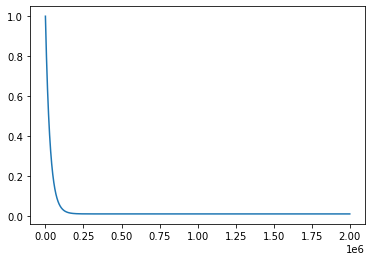

In [8]:
_epsilon = lambda frame: EPSILON_END + (EPSILON_START - EPSILON_END)*np.exp(-frame/EPSILON_DECAY)
plt.plot([_epsilon(frame) for frame in range(NUMBER_OF_FRAMES)]);

In [9]:
def evaluate(n_ep, a, env, is_creating_gif = False, is_showing = False):
    frames = []
    for _ in range(1):
        s, _ = env.reset()
        d = False
        while not d:
            #Render to frames buffer
            frames.append(env.render())
            action = a.act(s, epsilon)
            s, _, d, _, _ = env.step(action)

    if is_creating_gif:
        gif_file = "./boxing_" + str(n_ep) + ".gif"
        save_frames_as_gif(frames, filename=gif_file)
        clear_output(wait=True)
    
    if is_showing:
        b64 = base64.b64encode(open(gif_file,'rb').read()).decode('ascii')
        display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [10]:
env_id = ENVIRONMENT_ID
env    = make_atari(env_id, render_mode='rgb_array')
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

env.seed(seed)

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


(3444837047, 2669555309)

In [11]:
agent = DuelingAgent(env.observation_space.shape, env.action_space.n, MEMORY_CAPACITY, 
                 REPLAY_INITIAL, BATCH_SIZE, GAMMA, LEARNING_RATE, True)

In [12]:
summary(agent.policy_net)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,080
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       36,928
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-7                       1,606,144
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       513
├─Sequential: 1-3                        --
|    └─Linear: 2-10                      1,606,144
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      9,234
Total params: 3,293,875
Trainable params: 3,293,875
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,080
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       36,928
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-7                       1,606,144
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       513
├─Sequential: 1-3                        --
|    └─Linear: 2-10                      1,606,144
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      9,234
Total params: 3,293,875
Trainable params: 3,293,875
Non-trainable params: 0

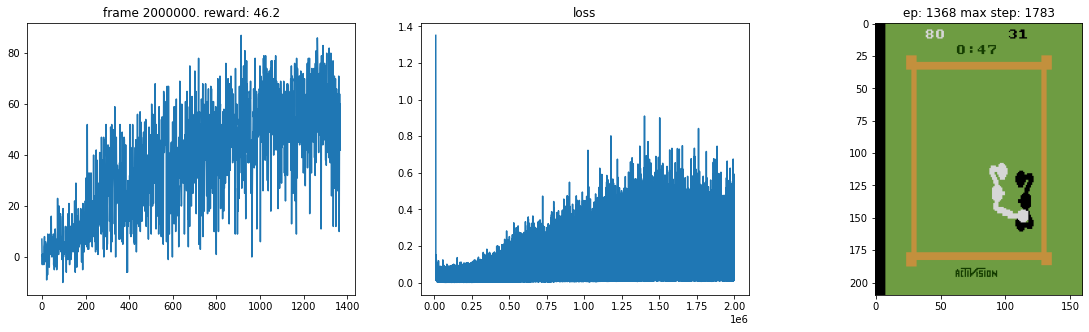

100%|██████████| 2000000/2000000 [4:32:10<00:00, 122.47it/s]


In [13]:
losses = []
all_rewards = []
episode_reward = 0
step = 0
ep = 0
max_steps = 0
is_showing_state = True

state, _ = env.reset()
for frame_idx in tqdm(range(1, NUMBER_OF_FRAMES + 1)):
    
    epsilon = _epsilon(frame_idx)
    action = agent.act(state, epsilon)
    
    next_state, reward, done, _, _ = env.step(action)
    agent.memorize(state, action, reward, next_state, float(done))
    
    state = next_state
    episode_reward += reward
    step += 1
    
    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
        if is_showing_state:
            evaluate(ep, agent, env, True)
            is_showing_state = False
            
        max_steps = max(step, max_steps)
        step = 0
        ep += 1
        gc.collect()

    loss = agent.experience_replay()
    losses.append(loss)
    
    if frame_idx % 500000 == 0:
        is_showing_state = True
        
    if frame_idx % 10000 == 0:
        rgb_array = env.render();
        plot(frame_idx, all_rewards, losses, rgb_array, (step, ep, max_steps))

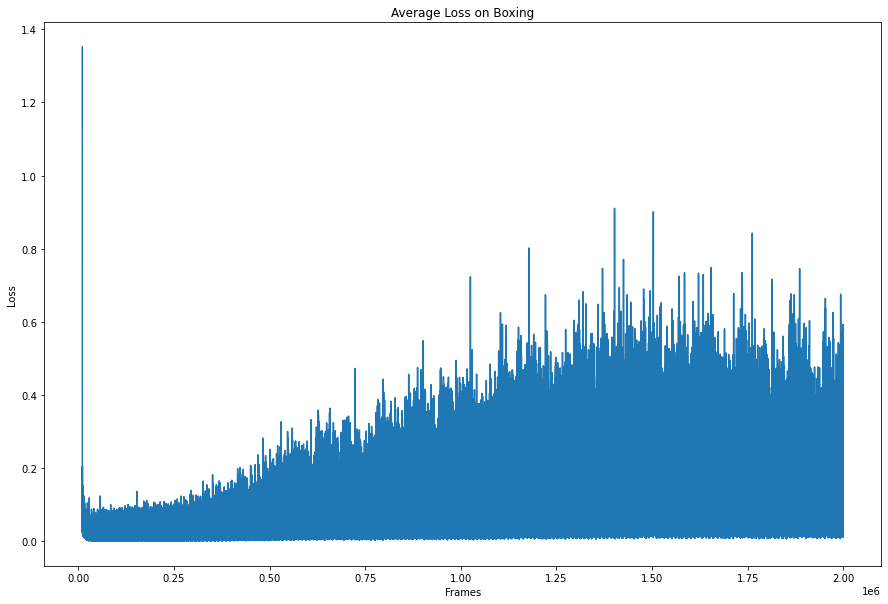

In [14]:
plot_loss_solo(losses, "Boxing")

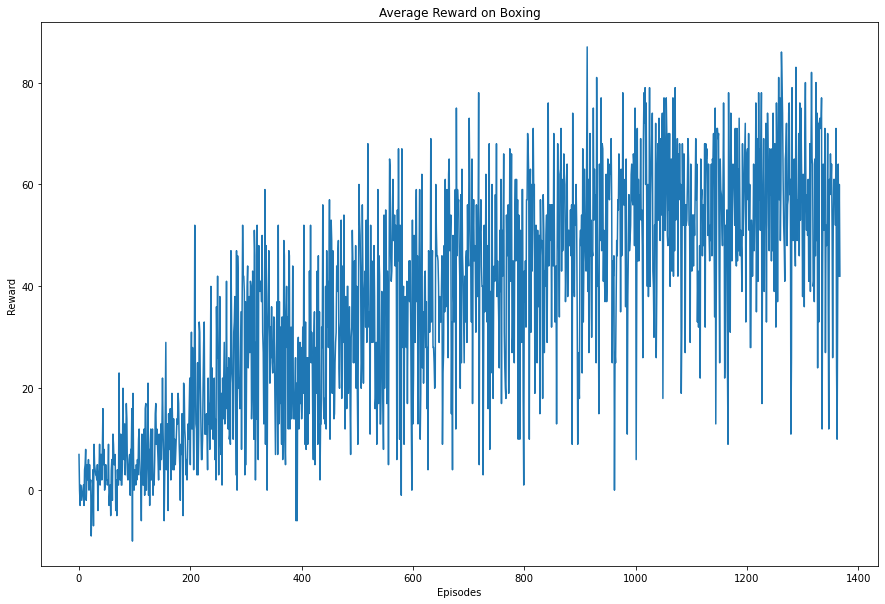

In [17]:
plot_reward_solo(all_rewards, "Boxing")

In [15]:
torch.save(agent.policy_net.state_dict(), "DuelingDQN_policy.pt")
torch.save(agent.target_net.state_dict(), "DuelingDQN_target.pt")


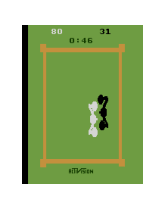

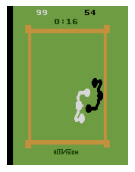

In [16]:
env.reset()

evaluate(ep, agent, env, True, True)

env.close()